In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d rgbnihal/c2a-dataset
!unzip c2a-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: C2A_Dataset/new_dataset3/train/labels/traffic_incident_image0189_1.txt  
  inflating: C2A_Dataset/new_dataset3/train/labels/traffic_incident_image0189_2.txt  
  inflating: C2A_Dataset/new_dataset3/train/labels/traffic_incident_image0189_3.txt  
  inflating: C2A_Dataset/new_dataset3/train/labels/traffic_incident_image0189_4.txt  
  inflating: C2A_Dataset/new_dataset3/train/labels/traffic_incident_image0190_0.txt  
  inflating: C2A_Dataset/new_dataset3/train/labels/traffic_incident_image0190_3.txt  
  inflating: C2A_Dataset/new_dataset3/train/labels/traffic_incident_image0191_0.txt  
  inflating: C2A_Dataset/new_dataset3/train/labels/traffic_incident_image0191_1.txt  
  inflating: C2A_Dataset/new_dataset3/train/labels/traffic_incident_image0191_2.txt  
  inflating: C2A_Dataset/new_dataset3/train/labels/traffic_incident_image0192_0.txt  
  inflating: C2A_Dataset/new_dataset3/train/labels/traffic_incident_image0192_4.txt  
  i

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.7 MB/s eta 0:00:00


In [ ]:
import kaggle
import transformers

import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GINConv, GATConv, global_mean_pool
from torch_geometric.data import Data
import torch_geometric.transforms as T

In [ ]:
# Example: Simplified node features (human positions, pose data)
node_features = torch.tensor([[1, 2], [2, 3], [3, 4]], dtype=torch.float)  # Replace with actual features

# Example: Edge index (connections between nodes) and edge features (distance, risk level)
edge_index = torch.tensor([[0, 1], [1, 2], [2, 0]], dtype=torch.long)
edge_features = torch.tensor([0.5, 0.8, 0.9], dtype=torch.float)  # Risk level, for example

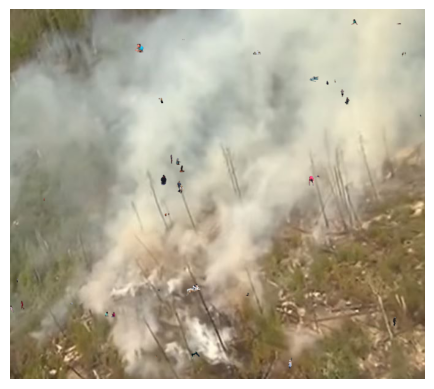

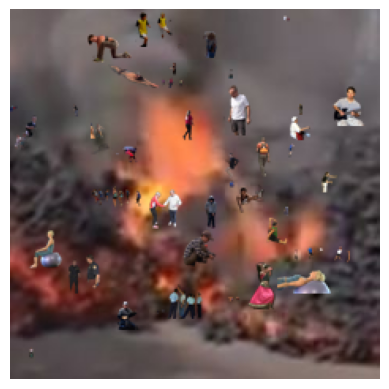

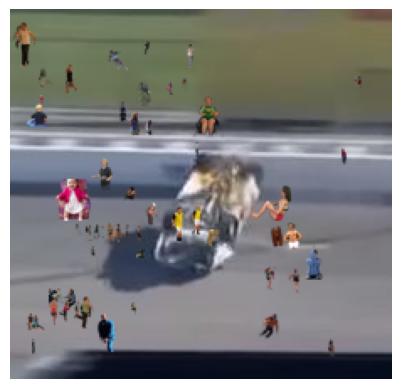

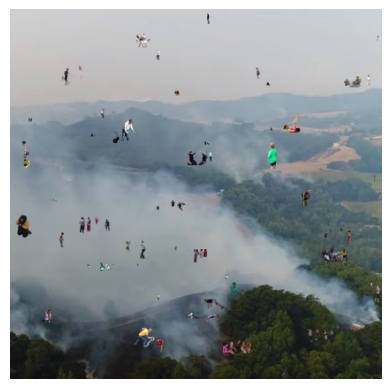

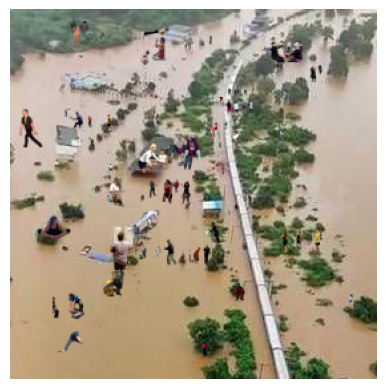

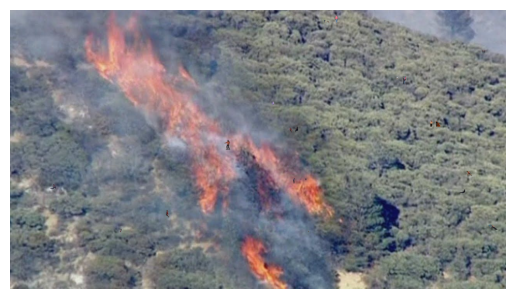

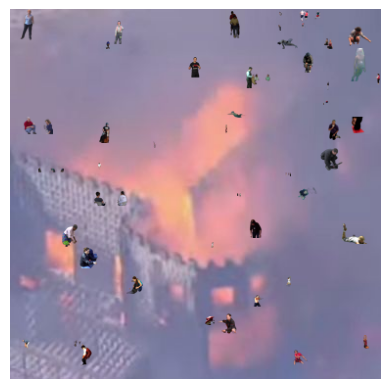

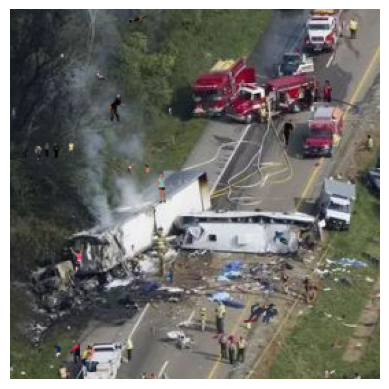

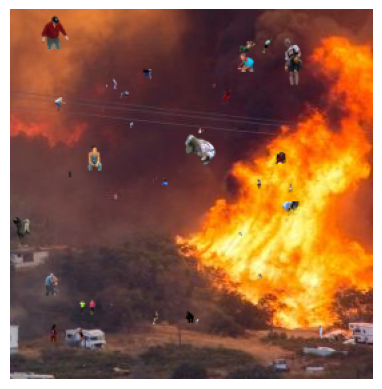

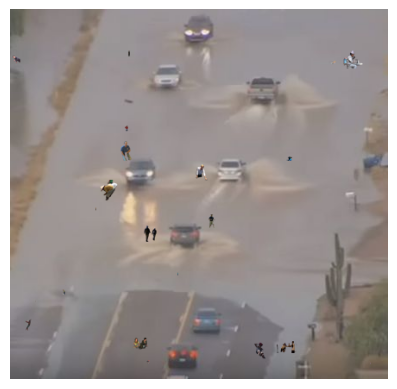

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os

image_folder = '/content/C2A_Dataset/new_dataset3/test/images'
image_files = os.listdir(image_folder)

for i in range(10):
    img = cv2.imread(os.path.join(image_folder, image_files[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:
class GIN_GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=50):
        super(GIN_GCN, self).__init__()

        self.num_layers = num_layers

        # Initial GIN layer (feature extraction)
        self.gin_layers = nn.ModuleList([GINConv(
            nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim)
            )
        ) for _ in range(num_layers)])

        # Final attention layer for graph reasoning
        self.attention = GATConv(hidden_dim, output_dim)

        # Final classifier
        self.fc = nn.Linear(output_dim, 3)  # Example: 3 classes for priority (High, Medium, Low)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        for i in range(self.num_layers):
            x = self.gin_layers[i](x, edge_index, edge_attr)
            x = torch.relu(x)

        # Attention mechanism for graph-wide reasoning
        x = self.attention(x, edge_index)

        # Pooling
        x = global_mean_pool(x, data.batch)

        # Final classification
        x = self.fc(x)
        return x

In [ ]:
train_dir = "/content/C2A_Dataset/new_dataset3/train/images"
test_dir  = "/content/C2A_Dataset/new_dataset3/test/images"
val_dir   = "/content/C2A_Dataset/new_dataset3/val/images"

train_labels  = "/content/C2A_Dataset/new_dataset3/train/labels"
test_labels   = "/content/C2A_Dataset/new_dataset3/test/Labels"
val_labels    = "/content/C2A_Dataset/new_dataset3/val/Labels"

In [ ]:
import os
import json
import numpy as np
from collections import deque
from tqdm import tqdm
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import random
import torch_geometric
from torch_geometric.nn import GINConv, GATConv, global_mean_pool
from torch_geometric.data import Data
import torch_geometric.transforms as T

In [ ]:
class C2ADataset(Dataset):
    def __init__(self, image_dir, annotation_file, transform=None, max_bboxes=50):
        """
        Args:
            image_dir (str): Path to images folder.
            annotation_file (str): Path to COCO-style JSON file.
            transform (callable, optional): Transformations for image augmentation.
            max_bboxes (int): Max number of bounding boxes per image (for padding).
        """
        self.image_dir = image_dir
        self.transform = transform
        self.max_bboxes = max_bboxes  # To ensure uniform batch sizes

        # Load the JSON annotation file
        with open(annotation_file, 'r') as f:
            self.coco_data = json.load(f)

        # Create a lookup table for annotations by image ID
        self.image_id_to_annotations = {}
        for ann in self.coco_data['annotations']:
            img_id = ann['image_id']
            if img_id not in self.image_id_to_annotations:
                self.image_id_to_annotations[img_id] = []
            self.image_id_to_annotations[img_id].append(ann)

        # Load image metadata
        self.image_metadata = {img['id']: img for img in self.coco_data['images']}

        # List of all image IDs
        self.image_ids = list(self.image_id_to_annotations.keys())

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        """
        Returns:
            image (Tensor): Transformed image.
            bboxes (Tensor): Bounding boxes (padded).
            poses (Tensor): Pose labels (padded).
            mask (Tensor): Indicates valid bounding boxes.
        """
        image_id = self.image_ids[idx]
        annotations = self.image_id_to_annotations[image_id]

        # Load image
        img_metadata = self.image_metadata[image_id]
        img_path = os.path.join(self.image_dir, img_metadata['file_name'])
        image = Image.open(img_path).convert("RGB")

        # Extract bounding boxes and poses
        bboxes = []
        poses = []
        for ann in annotations:
            bboxes.append(ann['bbox'])  # [x, y, w, h]
            poses.append(ann.get('pose', -1))  # Default pose = -1 if missing

        # Convert to tensors
        bboxes = torch.tensor(bboxes, dtype=torch.float32)
        poses = torch.tensor(poses, dtype=torch.long)

        # Padding: Make all tensors the same size (max_bboxes)
        num_bboxes = len(bboxes)
        if num_bboxes < self.max_bboxes:
            pad_size = self.max_bboxes - num_bboxes
            bboxes = torch.cat([bboxes, torch.zeros((pad_size, 4))], dim=0)
            poses = torch.cat([poses, torch.full((pad_size,), -1)])  # -1 for invalid poses
            mask = torch.cat([torch.ones(num_bboxes), torch.zeros(pad_size)])  # 1 = real, 0 = padded
        else:
            bboxes = bboxes[:self.max_bboxes]
            poses = poses[:self.max_bboxes]
            mask = torch.ones(self.max_bboxes)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, bboxes, poses, mask

# Define image transformations for EfficientNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Define dataset paths
image_dir = "/content/C2A_Dataset/new_dataset3/train/images"
annotation_file = "/content/Coco_annotation_pose/train_annotations_with_pose_information.json"

# Create dataset & dataloader
dataset = C2ADataset(image_dir, annotation_file, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Test dataloader
for images, bboxes, poses, mask in dataloader:
    print("Batch Image Shape:", images.shape)
    print("Bounding Boxes Shape:", bboxes.shape)  # Should be (batch_size, max_bboxes, 4)
    print("Poses Shape:", poses.shape)  # Should be (batch_size, max_bboxes)
    print("Mask Shape:", mask.shape)  # Indicates valid bounding boxes
    break

Batch Image Shape: torch.Size([8, 3, 224, 224])
Bounding Boxes Shape: torch.Size([8, 50, 4])
Poses Shape: torch.Size([8, 50])
Mask Shape: torch.Size([8, 50])


In [ ]:
# EfficientNet Feature Extractor
class EfficientNetFeatureExtractor(torch.nn.Module):
    def __init__(self, model_name="efficientnet_b0", feature_dim=1280):
        super(EfficientNetFeatureExtractor, self).__init__()

        # Load pretrained EfficientNet model
        self.efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

        # Remove the final classification layer
        self.feature_extractor = torch.nn.Sequential(*list(self.efficientnet.children())[:-1])

        # Final fully connected layer to adjust feature dimension (if needed)
        self.fc = torch.nn.Linear(1280, feature_dim)

    def forward(self, x):
        x = self.feature_extractor(x)  # Extract features
        x = x.view(x.size(0), -1)  # Flatten to (batch, 1280)
        x = self.fc(x)  # Feature transformation
        return x

# # Initialize the feature extractor
# feature_extractor = EfficientNetFeatureExtractor().cuda()

# # Test with a dummy image batch
# dummy_input = torch.randn(8, 3, 224, 224).cuda()  # Batch of 8 images
# features = feature_extractor(dummy_input)

# print("Feature Vector Shape:", features.shape)  # Expected: (8, feature_dim)

In [ ]:
# Load the COCO annotations
def load_annotations(annotation_path):
    with open(annotation_path, 'r') as f:
        annotations = json.load(f)
    return annotations["images"], annotations["annotations"]

In [ ]:
# Custom dataset to load images and crop human regions
class HumanDataset(Dataset):
    def __init__(self, image_dir, annotation_path, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images, self.annotations = load_annotations(annotation_path)

        # Organize annotations by image_id
        self.image_to_boxes = {}
        for ann in self.annotations:
            img_id = ann["image_id"]
            bbox = ann["bbox"]
            if img_id not in self.image_to_boxes:
                self.image_to_boxes[img_id] = []
            self.image_to_boxes[img_id].append(bbox)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_id = img_info["id"]
        img_path = os.path.join(self.image_dir, img_info["file_name"])

        # Load image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Get bounding boxes for this image
        bboxes = self.image_to_boxes.get(img_id, [])

        cropped_regions = []
        for bbox in bboxes:
            x, y, w, h = map(int, bbox)
            cropped = image[y:y+h, x:x+w]  # Crop human region

            if cropped.size == 0:  # Skip invalid crops
                continue

            cropped = Image.fromarray(cropped)
            if self.transform:
                cropped = self.transform(cropped)

            cropped_regions.append(cropped)

        if len(cropped_regions) == 0:
            return None  # Skip images with no valid bounding boxes

        return torch.stack(cropped_regions), img_id  # Return cropped humans

In [ ]:
# Define image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
def custom_collate_fn(batch):
    cropped_humans = []
    img_ids = []

    for item in batch:
        if item is None:
            continue
        humans, img_id = item
        cropped_humans.extend(humans)  # Extend list with cropped humans from each image
        img_ids.append(img_id)

    if len(cropped_humans) == 0:
        return None  # Skip empty batch

    return torch.stack(cropped_humans), img_ids  # Stack all cropped humans into a single batch

In [ ]:
# Dataset and Dataloader
image_dir = "/content/C2A_Dataset/new_dataset3/train/images"
annotation_path = "/content/Coco_annotation_pose/train_annotations_with_pose_information.json"

dataset = HumanDataset(image_dir, annotation_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=custom_collate_fn)

feature_extractor = EfficientNetFeatureExtractor().cuda()
feature_extractor.eval()

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 142MB/s] 


EfficientNetFeatureExtractor(
  (efficientnet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)


In [ ]:
# Extract and store features
all_features = []
all_ids = []

In [ ]:
with torch.no_grad():
    for cropped_humans, img_id in tqdm
     (dataloader, desc="Extracting Features", unit="batch"):
        cropped_humans = cropped_humans.cuda()
        features = feature_extractor(cropped_humans)  # Extract feature vectors
        all_features.append(features.cpu().numpy())
        all_ids.append(img_id)

# Save extracted features for training SAC
np.save("human_features.npy", np.vstack(all_features))
np.save("image_ids.npy", np.array(all_ids, dtype=object))  # Preserve list structure

print("Feature Extraction Completed. Saved feature vectors for RL training.")

Extracting Features: 100%|██████████| 767/767 [12:28<00:00,  1.02batch/s]


Feature Extraction Completed. Saved feature vectors for RL training.


In [ ]:
# SAC Actor Network (Policy)
class Actor(nn.Module):
    def __init__(self, input_dim, action_dim, hidden_dim=256):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, action_dim)  # Mean action
        self.log_std = nn.Linear(hidden_dim, action_dim)  # Log std dev for actions

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mu = self.mu(x)  # Mean action
        log_std = self.log_std(x).clamp(-20, 2)  # Clamped log std for stability
        std = log_std.exp()  # Convert log std to std

        return mu, std  # Returns action mean and std deviation

In [ ]:
# SAC Critic Network (Q-value estimators)
class Critic(nn.Module):
    def __init__(self, input_dim, action_dim, hidden_dim=256):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.q_value = nn.Linear(hidden_dim, 1)  # Single output Q-value

    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)  # Concatenate state and action
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.q_value(x)  # Predicted Q-value

In [ ]:
# Soft Q-learning Temperature Parameter (Entropy)
class Temperature(nn.Module):
    def __init__(self, initial_temp=1.0):
        super(Temperature, self).__init__()
        self.log_alpha = nn.Parameter(torch.tensor(initial_temp).log())  # Learnable alpha

    def forward(self):
        return self.log_alpha.exp()  # Convert log(alpha) to alpha

In [ ]:
# Load pre-extracted features
human_features = np.load("human_features.npy")  # State space
image_ids = np.load("image_ids.npy", allow_pickle=True)

In [ ]:
# Define action space (continuous: survival priority score)
ACTION_DIM = 1  # Single continuous action output (0 to 1)
STATE_DIM = human_features.shape[1]  # Number of extracted features

In [ ]:
# Hyperparameters
GAMMA = 0.99  # Discount factor
TAU = 0.005  # Target smoothing factor
ACTOR_LR = 3e-4
CRITIC_LR = 3e-4
BATCH_SIZE = 64
REPLAY_BUFFER_SIZE = 100000

# Initialize networks
actor = Actor(STATE_DIM, ACTION_DIM).cuda()
critic_1 = Critic(STATE_DIM, ACTION_DIM).cuda()
critic_2 = Critic(STATE_DIM, ACTION_DIM).cuda()
target_critic_1 = Critic(STATE_DIM, ACTION_DIM).cuda()
target_critic_2 = Critic(STATE_DIM, ACTION_DIM).cuda()
temperature = Temperature().cuda()

In [ ]:
# Copy critic weights to target networks
target_critic_1.load_state_dict(critic_1.state_dict())
target_critic_2.load_state_dict(critic_2.state_dict())

# Optimizers
actor_optimizer = optim.Adam(actor.parameters(), lr=ACTOR_LR)
critic_optimizer = optim.Adam(list(critic_1.parameters()) + list(critic_2.parameters()), lr=CRITIC_LR)
temp_optimizer = optim.Adam(temperature.parameters(), lr=ACTOR_LR)

In [ ]:
# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.tensor(states, dtype=torch.float32).cuda(),
            torch.tensor(actions, dtype=torch.float32).cuda(),
            torch.tensor(rewards, dtype=torch.float32).cuda(),
            torch.tensor(next_states, dtype=torch.float32).cuda(),
            torch.tensor(dones, dtype=torch.float32).cuda(),
        )

    def size(self):
        return len(self.buffer)

# Initialize Replay Buffer
replay_buffer = ReplayBuffer(REPLAY_BUFFER_SIZE)

# Define reward function (example heuristic: survival probability)
def compute_reward(human_id):
    # Placeholder: Assign survival probability based on dataset knowledge
    return np.random.uniform(0, 1)  # Replace with actual probability model

In [ ]:
# Training Loop
NUM_EPISODES = 200
UPDATE_AFTER = 1000
UPDATE_EVERY = 50

episode_rewards_list = []
average_rewards_list = []
window_size = 10

for episode in tqdm(range(NUM_EPISODES), desc="Training SAC", unit="episode"):
    state = human_features[np.random.randint(0, len(human_features))]
    done = False
    episode_reward = 0
    step_count = 0

    while not done:
        step_count += 1

        state_tensor = torch.tensor(state, dtype=torch.float32).cuda().unsqueeze(0)

        with torch.no_grad():
            mu, std = actor(state_tensor)
            action = mu + std * torch.randn_like(std)
            action = torch.clamp(action, 0, 1).cpu().numpy()[0]

        next_state = human_features[np.random.randint(0, len(human_features))]
        reward = compute_reward(image_ids[np.random.randint(0, len(image_ids))])
        done = np.random.rand() < 0.1

        replay_buffer.add(state, action, reward, next_state, done)

        state = next_state
        episode_reward += reward

        if replay_buffer.size() > UPDATE_AFTER and episode % UPDATE_EVERY == 0:
            for _ in tqdm(range(10), desc=f"Updating SAC (Ep {episode})", leave=False):
                states, actions, rewards, next_states, dones = replay_buffer.sample(BATCH_SIZE)

                with torch.no_grad():
                    next_mu, next_std = actor(next_states)
                    next_actions = next_mu + next_std * torch.randn_like(next_std)
                    next_actions = torch.clamp(next_actions, 0, 1)

                    q1_next = target_critic_1(next_states, next_actions)
                    q2_next = target_critic_2(next_states, next_actions)
                    q_next = torch.min(q1_next, q2_next)

                    target_q = rewards + GAMMA * (1 - dones) * q_next.squeeze()

                q1 = critic_1(states, actions).squeeze()
                q2 = critic_2(states, actions).squeeze()
                critic_loss = F.mse_loss(q1, target_q) + F.mse_loss(q2, target_q)

                critic_optimizer.zero_grad()
                critic_loss.backward()
                critic_optimizer.step()

                mu, std = actor(states)
                sampled_actions = mu + std * torch.randn_like(std)
                sampled_actions = torch.clamp(sampled_actions, 0, 1)

                q1_new = critic_1(states, sampled_actions)
                q2_new = critic_2(states, sampled_actions)
                q_new = torch.min(q1_new, q2_new)

                alpha = temperature()
                actor_loss = (alpha * sampled_actions - q_new).mean()

                actor_optimizer.zero_grad()
                actor_loss.backward()
                actor_optimizer.step()

                temp_loss = -temperature().mean()
                temp_optimizer.zero_grad()
                temp_loss.backward()
                temp_optimizer.step()

                for target_param, param in zip(target_critic_1.parameters(), critic_1.parameters()):
                    target_param.data.copy_(TAU * param.data + (1 - TAU) * target_param.data)

                for target_param, param in zip(target_critic_2.parameters(), critic_2.parameters()):
                    target_param.data.copy_(TAU * param.data + (1 - TAU) * target_param.data)

    episode_rewards_list.append(episode_reward)

    if episode >= window_size:
        avg_reward = np.mean(episode_rewards_list[-window_size:])
    else:
        avg_reward = np.mean(episode_rewards_list)
    average_rewards_list.append(avg_reward)

    print(f"Episode {episode + 1}/{NUM_EPISODES}, Reward: {episode_reward:.2f}, Avg Reward (Last {window_size}): {avg_reward:.2f}")

print("SAC Training Completed.")

Updating SAC (Ep 0):  80%|████████  | 8/10 [00:00<00:00, 33.17it/s]
                                                                   
Updating SAC (Ep 0):  80%|████████  | 8/10 [00:00<00:00, 32.65it/s]
                                                                   
Updating SAC (Ep 0):  70%|███████   | 7/10 [00:00<00:00, 30.32it/s]
                                                                   
Updating SAC (Ep 0):  80%|████████  | 8/10 [00:00<00:00, 33.11it/s]
                                                                   
Updating SAC (Ep 0):  80%|████████  | 8/10 [00:00<00:00, 32.78it/s]
                                                                   
Updating SAC (Ep 0): 100%|██████████| 10/10 [00:00<00:00, 29.73it/s]
                                                                    
Updating SAC (Ep 0):  80%|████████  | 8/10 [00:00<00:00, 32.36it/s]
                                                                   
Updating SAC (Ep 0):  80%|████████  | 8/10 [00

Episode 1/200, Reward: 4.88
Episode 2/200, Reward: 6.05
Episode 3/200, Reward: 2.99
Episode 4/200, Reward: 2.39
Episode 5/200, Reward: 5.58
Episode 6/200, Reward: 7.06
Episode 7/200, Reward: 4.66
Episode 8/200, Reward: 2.02
Episode 9/200, Reward: 11.18
Episode 10/200, Reward: 4.15
Episode 11/200, Reward: 0.08
Episode 12/200, Reward: 6.09
Episode 13/200, Reward: 23.34
Episode 14/200, Reward: 0.78
Episode 15/200, Reward: 1.15
Episode 16/200, Reward: 0.83
Episode 17/200, Reward: 9.52
Episode 18/200, Reward: 0.26
Episode 19/200, Reward: 27.18
Episode 20/200, Reward: 2.80
Episode 21/200, Reward: 7.63
Episode 22/200, Reward: 2.07
Episode 23/200, Reward: 4.75
Episode 24/200, Reward: 4.52
Episode 25/200, Reward: 2.60
Episode 26/200, Reward: 1.37
Episode 27/200, Reward: 1.85
Episode 28/200, Reward: 7.64
Episode 29/200, Reward: 7.60
Episode 30/200, Reward: 7.39
Episode 31/200, Reward: 0.83
Episode 32/200, Reward: 3.22
Episode 33/200, Reward: 14.63
Episode 34/200, Reward: 10.92
Episode 35/200, Re

Training SAC:  19%|█▉        | 38/200 [00:03<00:08, 18.27episode/s]

Episode 37/200, Reward: 2.28
Episode 38/200, Reward: 0.74
Episode 39/200, Reward: 6.58
Episode 40/200, Reward: 1.50
Episode 41/200, Reward: 1.39
Episode 42/200, Reward: 10.98
Episode 43/200, Reward: 2.75
Episode 44/200, Reward: 2.28
Episode 45/200, Reward: 4.73
Episode 46/200, Reward: 3.10
Episode 47/200, Reward: 5.90
Episode 48/200, Reward: 3.17
Episode 49/200, Reward: 8.06
Episode 50/200, Reward: 1.30



Updating SAC (Ep 50):  80%|████████  | 8/10 [00:00<00:00, 30.44it/s]
                                                                    
Updating SAC (Ep 50):  80%|████████  | 8/10 [00:00<00:00, 32.43it/s]
                                                                    
Training SAC:  36%|███▌      | 72/200 [00:04<00:04, 26.82episode/s]

Episode 51/200, Reward: 1.74
Episode 52/200, Reward: 0.06
Episode 53/200, Reward: 0.34
Episode 54/200, Reward: 1.39
Episode 55/200, Reward: 3.02
Episode 56/200, Reward: 7.26
Episode 57/200, Reward: 1.34
Episode 58/200, Reward: 6.26
Episode 59/200, Reward: 6.57
Episode 60/200, Reward: 3.27
Episode 61/200, Reward: 2.17
Episode 62/200, Reward: 0.20
Episode 63/200, Reward: 15.64
Episode 64/200, Reward: 11.57
Episode 65/200, Reward: 5.93
Episode 66/200, Reward: 16.02
Episode 67/200, Reward: 5.37
Episode 68/200, Reward: 4.14
Episode 69/200, Reward: 11.54
Episode 70/200, Reward: 1.86
Episode 71/200, Reward: 0.89
Episode 72/200, Reward: 10.13
Episode 73/200, Reward: 0.38
Episode 74/200, Reward: 0.89
Episode 75/200, Reward: 13.09
Episode 76/200, Reward: 1.35
Episode 77/200, Reward: 1.96
Episode 78/200, Reward: 8.32
Episode 79/200, Reward: 1.80
Episode 80/200, Reward: 23.90
Episode 81/200, Reward: 11.44
Episode 82/200, Reward: 3.51
Episode 83/200, Reward: 6.19


Training SAC:  44%|████▎     | 87/200 [00:04<00:03, 36.44episode/s]

Episode 84/200, Reward: 17.33
Episode 85/200, Reward: 1.63
Episode 86/200, Reward: 1.41
Episode 87/200, Reward: 0.77
Episode 88/200, Reward: 5.93
Episode 89/200, Reward: 1.57
Episode 90/200, Reward: 8.93
Episode 91/200, Reward: 8.89
Episode 92/200, Reward: 3.15
Episode 93/200, Reward: 5.97
Episode 94/200, Reward: 7.95
Episode 95/200, Reward: 9.66
Episode 96/200, Reward: 2.78
Episode 97/200, Reward: 6.60
Episode 98/200, Reward: 2.79
Episode 99/200, Reward: 5.80
Episode 100/200, Reward: 2.98



Updating SAC (Ep 100):  70%|███████   | 7/10 [00:00<00:00, 31.50it/s]
                                                                     
Updating SAC (Ep 100):  80%|████████  | 8/10 [00:00<00:00, 33.41it/s]
                                                                     
Training SAC:  64%|██████▎   | 127/200 [00:05<00:01, 40.30episode/s]

Episode 101/200, Reward: 1.37
Episode 102/200, Reward: 7.29
Episode 103/200, Reward: 0.67
Episode 104/200, Reward: 10.67
Episode 105/200, Reward: 7.33
Episode 106/200, Reward: 2.45
Episode 107/200, Reward: 0.71
Episode 108/200, Reward: 3.20
Episode 109/200, Reward: 17.01
Episode 110/200, Reward: 6.42
Episode 111/200, Reward: 0.98
Episode 112/200, Reward: 2.68
Episode 113/200, Reward: 6.83
Episode 114/200, Reward: 7.08
Episode 115/200, Reward: 4.94
Episode 116/200, Reward: 2.25
Episode 117/200, Reward: 5.04
Episode 118/200, Reward: 2.51
Episode 119/200, Reward: 7.77
Episode 120/200, Reward: 0.30
Episode 121/200, Reward: 0.97
Episode 122/200, Reward: 0.59
Episode 123/200, Reward: 0.80
Episode 124/200, Reward: 2.88
Episode 125/200, Reward: 2.86
Episode 126/200, Reward: 1.37
Episode 127/200, Reward: 2.54
Episode 128/200, Reward: 6.39
Episode 129/200, Reward: 0.06
Episode 130/200, Reward: 0.10
Episode 131/200, Reward: 6.61
Episode 132/200, Reward: 8.27
Episode 133/200, Reward: 12.04
Episode

Training SAC:  74%|███████▍  | 148/200 [00:05<00:00, 55.02episode/s]

Episode 148/200, Reward: 11.53
Episode 149/200, Reward: 5.44
Episode 150/200, Reward: 0.90



Updating SAC (Ep 150):  80%|████████  | 8/10 [00:00<00:00, 32.62it/s]
                                                                     
Updating SAC (Ep 150):  80%|████████  | 8/10 [00:00<00:00, 32.88it/s]
                                                                     
Updating SAC (Ep 150):  80%|████████  | 8/10 [00:00<00:00, 30.59it/s]
                                                                     
Updating SAC (Ep 150):  80%|████████  | 8/10 [00:00<00:00, 32.86it/s]
                                                                     
Updating SAC (Ep 150):  80%|████████  | 8/10 [00:00<00:00, 32.75it/s]
                                                                     
Updating SAC (Ep 150):  80%|████████  | 8/10 [00:00<00:00, 30.82it/s]
                                                                     
Updating SAC (Ep 150):  80%|████████  | 8/10 [00:00<00:00, 32.16it/s]
                                                                     
Updating SAC (Ep 15

Episode 151/200, Reward: 8.07
Episode 152/200, Reward: 2.46
Episode 153/200, Reward: 0.77
Episode 154/200, Reward: 8.81
Episode 155/200, Reward: 1.98
Episode 156/200, Reward: 0.88
Episode 157/200, Reward: 5.22
Episode 158/200, Reward: 1.61
Episode 159/200, Reward: 8.12
Episode 160/200, Reward: 4.06
Episode 161/200, Reward: 5.40
Episode 162/200, Reward: 4.68
Episode 163/200, Reward: 3.62
Episode 164/200, Reward: 13.99
Episode 165/200, Reward: 3.21
Episode 166/200, Reward: 1.15
Episode 167/200, Reward: 7.94
Episode 168/200, Reward: 10.70
Episode 169/200, Reward: 0.51
Episode 170/200, Reward: 9.76
Episode 171/200, Reward: 2.58
Episode 172/200, Reward: 0.48
Episode 173/200, Reward: 0.74
Episode 174/200, Reward: 13.11
Episode 175/200, Reward: 0.11
Episode 176/200, Reward: 0.91
Episode 177/200, Reward: 4.78
Episode 178/200, Reward: 8.52
Episode 179/200, Reward: 7.65
Episode 180/200, Reward: 10.08
Episode 181/200, Reward: 0.82
Episode 182/200, Reward: 5.90
Episode 183/200, Reward: 8.66
Episod

Training SAC: 100%|██████████| 200/200 [00:12<00:00, 15.61episode/s]

Episode 191/200, Reward: 6.44
Episode 192/200, Reward: 4.53
Episode 193/200, Reward: 6.30
Episode 194/200, Reward: 0.72
Episode 195/200, Reward: 8.15
Episode 196/200, Reward: 8.46
Episode 197/200, Reward: 2.20
Episode 198/200, Reward: 0.68
Episode 199/200, Reward: 0.63
Episode 200/200, Reward: 1.67
SAC Training Completed.
